In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
#from skimage.feature import greycomatrix,greycoprops

In [2]:
data_path = r'C:\Users\mmatr\Desktop\Data Science\IBM Machine Learning\Git\IBM-Machine-Learning-Course\Course_5_Deep_Learning\NEU Metal Surface Defects Data'
os.chdir(data_path)


In [3]:
def mse(a,b):
    """function to compute the mean square error between two numpy arrays"""
    return np.square(a-b).mean()

def load_images(data_path):
    """Function to load images from NEU Dataset"""

    images=[] 
    labels=[] 

    for dirpath, dirnames, filenames in os.walk(data_path):
        for filename in filenames:
            defect=dirpath.split('\\')[-1] 
            if '.bmp' in filename:
                images.append(cv2.imread(os.path.join(dirpath,filename),0))
                labels.append(defect)

    images=np.asarray(images)
    labels=np.asarray(labels)

    return images, labels

I anticipate reuse of the following function to use the Train/Test/Validation Splits provided in the dataset.
However, as these splits are unbalanced (1656/72/72),constructing a larger test set may be appropriate.


I will proceed by loading all of the data into a single dataset and using a 15% test train split.


In [4]:
#load the data.
data, labels = load_images(data_path)

# train_images, train_labels = load_images(data_path + r'\train')
# val_images, val_labels = load_images(data_path + r'\valid')
# test_images, test_labels = load_images(data_path + r'\test')

In [5]:
#ensure labels came in correctly 
Counter(labels)


Counter({'Crazing': 300,
         'Inclusion': 300,
         'Patches': 300,
         'Pitted': 300,
         'Rolled': 300,
         'Scratches': 300})

# Context

Gray Scale intensities range from 0-255. 

The baseline classifier for this project is simply a comparison of contrast distribution in each image.  Normalized pixel intensity for each class will be calculated and displayed on a connected scatter plot.  Then, the mean square error (MSE) of each image with respect to the normalized intensity for each class will be computed.  The class the yields the lowest MSE will be the prediction for that image. 

Limitation of this analysis include:

Image quality. Even among images in the same class, background intensities vary significantly.  The images do not appear to be collected in a standardized manner.  

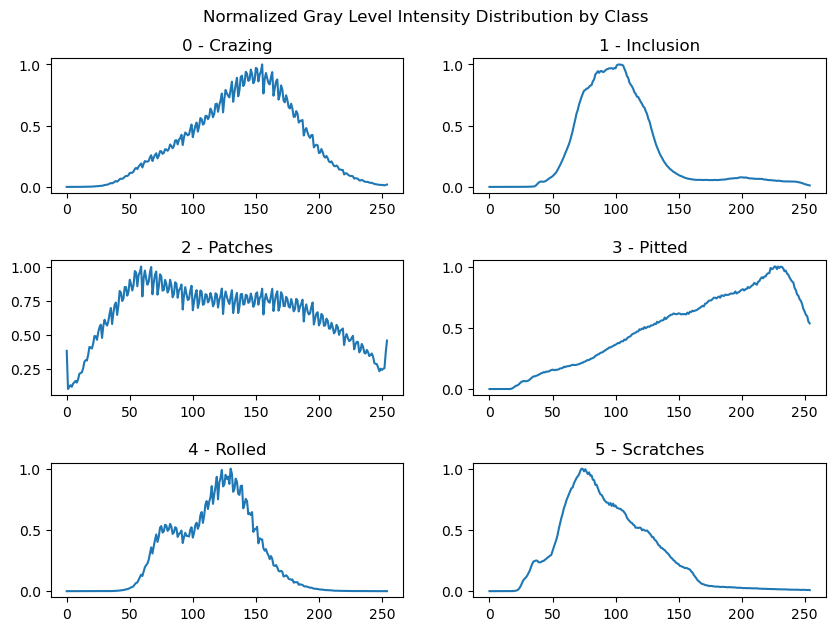

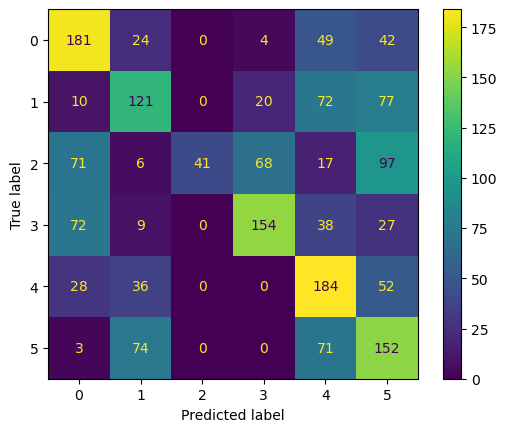

number of correct predictions =  833
total samples =  1800
accuracy =  0.463


In [6]:
#Building a basing classifier (contrast only) - based on the whole dataset

fig, axs = plt.subplots(3, 2, figsize=(10,7))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Normalized Gray Level Intensity Distribution by Class", fontsize=12, y=0.95)

hists=[]

#this loop determines the normalized contrast distribution for each category
for i, (case,ax) in enumerate(zip(np.unique(labels), axs.ravel())):
    
    hist=np.zeros((256,1))

    cr = labels[labels==case]
    crd = data[labels==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])
    
    lb=0
    ub=-1
    hist=hist[lb:ub]  
    index=hist.shape

    ax.plot(hist/max(hist))
    ax.set_title(str(i) + " - " + case)
    hists.append(hist/max(hist))
    
correct=0
count=0
true=[]
prediction=[]

#this loop compares each image to the average distribution and classifies the image according to the lowest MSE
for i,case in enumerate(np.unique(labels)):

    cr = labels[labels==case]
    crd = data[labels==case]
    

    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist = hist[lb:ub]
        histn=hist/max(hist)
        
        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])
        
        pred=np.argmin(msarray)
                

        if pred == i:
            correct+=1

        true.append(i)
        prediction.append(pred)


    
conmat = confusion_matrix(true,prediction)
disp = ConfusionMatrixDisplay(conmat)
disp.plot()
plt.show()

print("number of correct predictions = ", correct)
print("total samples = ", len(data))
print("accuracy = ", round(accuracy_score(true,prediction),3))

In [7]:
#this code was used for determining which two classes were the most different

storage=[]
index=[]
for i, dist in enumerate(hists):
    if i<len(hists):
        for j,dist2 in enumerate(hists[i+1:]):
            index.append((i,j+i+1))
            storage.append(round(mse(dist,dist2),3))
          

In [51]:
inds=index[storage.index(max(storage))]
l2=np.unique(labels)

print(str(l2[inds[0]]) + ' and ' + str(l2[inds[1]]) + ' are the most different on average.')

Pitted and Scratches are the most different on average


The following cell uses a train test split so that the predictor has new data to be tested against

In [52]:
#Building a basing classifier (contrast only) - based on a train/test split

hists=[]
# The first loop calculates the pixel intensity distribution for each class
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

for case in np.unique(labels):
    
    hist=np.zeros((256,1))

    cr = y_train[y_train==case]
    crd = X_train[y_train==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])

    lb=0
    ub=-1
    hist=hist[lb:ub]   

    hists.append(hist/max(hist))

correct=0
true=[]
prediction=[]

# The second loop calculates the pixel intensity distribution for each image and calculates
# the mse wrt each class.
for ii, case in enumerate(np.unique(labels)):

    cr = y_test[y_test==case]
    crd = X_test[y_test==case]


    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist=hist[lb:ub]
        histn=hist/max(hist)

        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

        pred=np.argmin(msarray)


        if pred == ii:
            correct+=1

        true.append(ii)
        prediction.append(pred)
        
print("number of correct predictions = ", correct)
print("total samples = ", len(y_test))
print("accuracy = ", round(accuracy_score(true,prediction),3))


number of correct predictions =  261
total samples =  594
accuracy =  0.439


# Experiment 

The following code was implemented to run the classifier 1000 times to plot the accuracy distribution.  The CLT should hold meaning the distribution should be approximately normal.  The code is commented out because it takes a while to run and was purely for my own curiosity. 
 

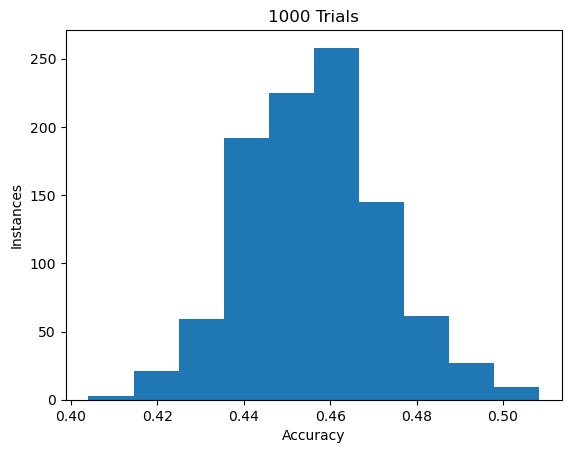

In [9]:
# accuracy=[]


# for jj in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)
#     hists=[]
#     for case in np.unique(labels):
#         #print(case)
#         hist=np.zeros((256,1))

#         cr = y_train[y_train==case]
#         crd = X_train[y_train==case]

#         for image in crd:
#             hist += cv2.calcHist([image],[0],None,[256],[0,256])

#         lb=0
#         ub=-1
#         hist=hist[lb:ub]      

#         hists.append(hist/max(hist))

#     correct=0
#     count=0
#     true=[]
#     prediction=[]
#     for ii,case in enumerate(np.unique(labels)):

#         cr = y_test[y_test==case]
#         crd = X_test[y_test==case]


#         for image in crd:
#             hist = cv2.calcHist([image],[0],None,[256],[0,256])
#             hist=hist[lb:ub] 
#             histn=hist/max(hist)

#             msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

#             pred=np.argmin(msarray)


#             if pred == ii:
#                 correct+=1

#             true.append(ii)
#             prediction.append(pred)




#     accuracy.append(accuracy_score(true,prediction))

# plt.hist(accuracy)
# plt.xlabel('Accuracy')
# plt.ylabel('Instances')
# plt.title('1000 Trials')
# plt.show()


The results from the above cell are shown here:


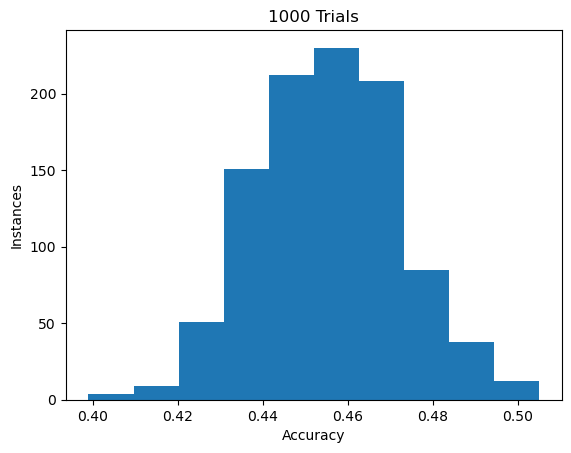